## **Udacity: Introduction to TensorFlow for Deep Learning**

**Lesson 8 PART 2**

This lessons was an introduction to time series analysis, in particular time series forecasting.

Concepts introduced
- Preparing time series data for model training
- Using the learning rate scheduler to optimize the model's learning rate
- Huber loss function being much more suited for minimzing the mae
- SGD optimizer with set learning rate and momentum


## **Import Dependencies**


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


## **Preparing a time series data for Machine learning**

Towards forecasting a time series with an ML model, we need to build a model that would forecast the next time step for a given time window. example
- given  $t_{0} - t_{9}$ the model would forecast the value at $t_{10}$
- given  $t_{13} - t_{22}$ the model would forecast the value at $t_{23}$

<br/>

Towards this, we would have to prepare the time series dataset by
- defining a window size for the time series.
- creating a dataset from the time series containing all possible time windows

<br/>

So the resulting training data would contains the time window as the input feature and the next time step value as the label.

In [2]:
# create an example time series containing values from 0 - 9
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

# this is equivalent to
dataset_np = np.arange(0,10)
print('\n', dataset_np)


0
1
2
3
4
5
6
7
8
9

 [0 1 2 3 4 5 6 7 8 9]


In [3]:
# Get all possible windows of 5 consecutive time steps
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=' ')
  print()
  

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


window methods returns a datasets of windowed dataset

In [4]:
# We can remove the short windows to ensure all our windows are the same size
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=' ')
  print()


0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


convert each window dataset into a tensor

In [6]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Split the dataset into our features and label

In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],  window[-1:]))

for x, y in dataset:
  print(x.numpy(), y.numpy())


[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Shuffle the windows and create a batched dataset

In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


x =  [[1 2 3 4]
 [3 4 5 6]]
y =  [[5]
 [7]]
x =  [[0 1 2 3]
 [4 5 6 7]]
y =  [[4]
 [8]]
x =  [[2 3 4 5]
 [5 6 7 8]]
y =  [[6]
 [9]]


The whole pipeline above can be converted into a single function to create our time series dataset

In [9]:
def window_dataset(series, window_size, batch_size=32):
  """Function preprares a time series by creating a windowed dataset with a
  specified window size and batch size.
  """
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  ds = ds.shuffle(len(series))
  return ds.batch(batch_size).prefetch(1)


## **Get the dataset from the previous collab notebook**

The instructor re-uses the same dataset and code from previous sections of the lesson. I need to add them back in, to this notebook.

In [10]:
# define the trend function
def trend(time, slope=0):
  """Function returns a time series with the specified slope."""
  return slope*time


# define the seasonality function
def seasonal_pattern(time_step):
  """Returns the output of a trig function."""
  return np.where(time_step < 0.4,
                  np.cos(time_step * 2 * np.pi),
                  1 / np.exp(3 * time_step))

def seasonality(time, period, amplitude, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# define a function to add the white noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# define function to plot the time series
def plot_series(time, series, format='-', start=0, end=None, label=None):
  """Plots a time series on a graph.
  Args
    - time (1d array): contains time steps for the series
    - series (1d array): contains values for the time series at each time step
  """
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)



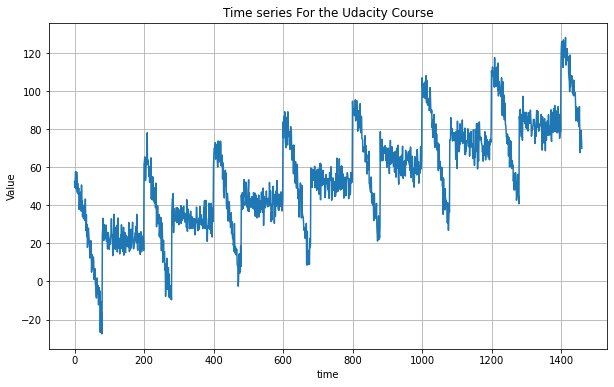

In [11]:
# define the time series
slope = 0.05
Period = 200
Max_amplitude = 40
noise_level = 5
baseline = 10

time = np.arange(4 * 365 + 1)
series = baseline + trend(time, slope) + seasonality(time, Period, Max_amplitude) + white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.title('Time series For the Udacity Course')
plt.show()


Split the time series into a training and validation set

In [12]:
Split_time = 1000

# Training period: 0 - 1000
x_train = series[:Split_time]
time_train = time[:Split_time]


# Validation period: 1000 - end
x_valid = series[Split_time:]
time_valid = time[Split_time:]


## **Train a Simple Linear Regression Model to Forecast the data**

Model being used
- Keras sequential model containing a single dense layer with a single neuron and no activation function
- The SGD optimizer is used with some momentum
- The huber loss function is used.
- The mean absolute error is used as our main metric.

<br/>

**Huber Loss function**
- This loss function is much better at minimizing the mean absolute error.
- It's behaviour is such that it is quadratic for small errors and linear for large errors.

<br/>

**Concepts introduced**
- Learning rate scheduler to select the a model's learning rate.

In [16]:
# set random seeds inorder to get repeatable results
tf.random.set_seed(42)
np.random.seed(42)


# create the training and validation dataset
window_size = 30
train_set_ds = window_dataset(x_train, window_size)
valid_set_ds = window_dataset(x_valid, window_size)


In [15]:
# define a simple linear regression model

# input shape = window_size. Because it would use that as the input to train the model on for each epoch
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [19]:
# define the model optimizer, loss and metrics

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
              metrics=["mae"])


In [21]:
# train the model

model.fit(train_set_ds, epochs=100,
          validation_data = valid_set_ds)


Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 47.5951 - mae: 48.0932 - val_loss: 24.4227 - val_mae: 24.9220
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 14.2865 - mae: 14.7765 - val_loss: 12.7406 - val_mae: 13.2322
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 12.4236 - mae: 12.9152 - val_loss: 12.7727 - val_mae: 13.2624
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 12.0826 - mae: 12.5733 - val_loss: 12.0101 - val_mae: 12.4966
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 11.8107 - mae: 12.3030 - val_loss: 11.6390 - val_mae: 12.1247
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 11.5024 - mae: 11.9888 - val_loss: 11.3251 - val_mae: 11.8082
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 11.2879 - mae: 11.7749 - val_loss: 11.0760 - val_mae: 11.5601
Epoch 8/100
31/31 [==============================] - 0

**Using LearningRateSchedulder**

Demo on how to use the learning rate scheduler to select the best learning rate for our SGD optimizer.

In [22]:
# define the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:  1e-6 * 10**(epoch/30)) # increase the learning rate by a factor of 10 every 30 epochs


In [23]:
# define a new model to train
model_2 = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [24]:
# compile the model
model_2.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              metrics=["mae"])


In [ ]:
# train the model using the learning rate scheduler
history = model_2.fit(train_set_ds, epochs=100, callbacks=[lr_schedule])


Plot the learning rate against the loss function

(1e-06, 0.001, 0.0, 20.0)

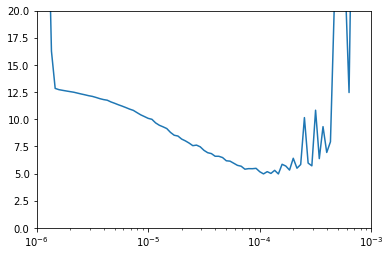

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])


The good learning rate would be somewhere before the unstable part. So it seams like 10-4 would be a good learning rate.

In [29]:
# Define a new model with the same model architecture, loss, optimizer and metrics
# but this time select the optimal learning rate
model_3 = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
model_3.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                metrics=['mae'])


In [30]:
# Train the model on the training set and validate on the validation set
# Use the early stopping callback to prevent overfitting
Early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history = model_3.fit(train_set_ds, epochs=100,
                      validation_data=valid_set_ds,
                      callbacks=[Early_stopping])


Epoch 1/100
31/31 [==============================] - 1s 12ms/step - loss: 7.8017 - mae: 8.2876 - val_loss: 8.4484 - val_mae: 8.9343
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 6.7956 - mae: 7.2796 - val_loss: 7.1325 - val_mae: 7.6164
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 6.4470 - mae: 6.9314 - val_loss: 8.7712 - val_mae: 9.2581
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 6.9116 - mae: 7.3967 - val_loss: 5.9124 - val_mae: 6.3962
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 6.1036 - mae: 6.5833 - val_loss: 5.9316 - val_mae: 6.4082
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 6.0554 - mae: 6.5378 - val_loss: 8.9310 - val_mae: 9.4210
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 5.6033 - mae: 6.0867 - val_loss: 10.5683 - val_mae: 11.0649
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 5.9087 

Now to make predictions using the trained models. The model predictions would be made on the validation set

In [31]:
#  define a function to prepare a dataset and make predictions on.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast


In [34]:
# Make predictions on the validation set
lin_forecast_1 = model_forecast(model, series[Split_time - window_size:-1], window_size)[:, 0]
lin_forecast_2 = model_forecast(model_2, series[Split_time - window_size:-1], window_size)[:, 0]
lin_forecast_3 = model_forecast(model_3, series[Split_time - window_size:-1], window_size)[:, 0]


Text(0.5, 1.0, 'Model 1 forecast on the validation set')

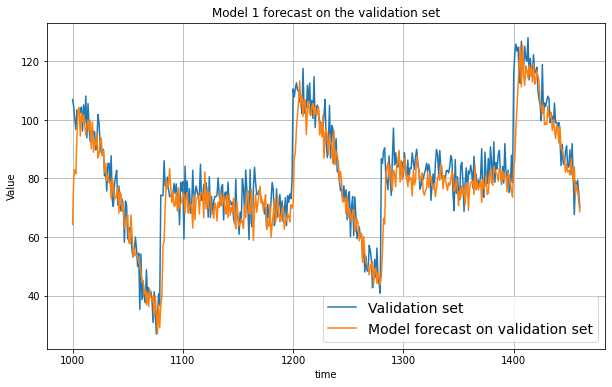

In [35]:
# plot the forecast against the actual values

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Validation set')
plot_series(time_valid, lin_forecast_1, label='Model forecast on validation set')
plt.title("Model 1 forecast on the validation set")


Text(0.5, 1.0, 'Model 2 forecast on validation set')

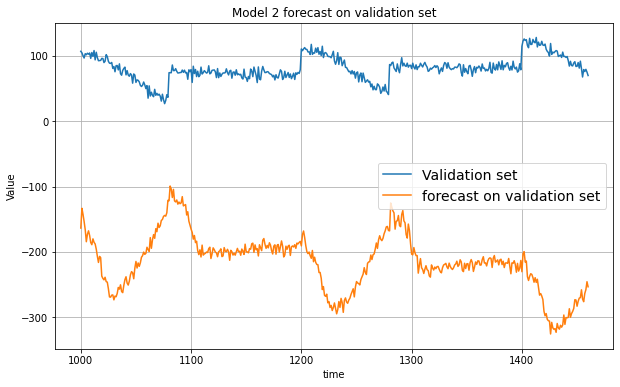

In [37]:
# plot forecast for the second model

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Validation set')
plot_series(time_valid, lin_forecast_2, label='forecast on validation set')
plt.title("Model 2 forecast on validation set")


Text(0.5, 1.0, 'Model 3 forecast on validation set')

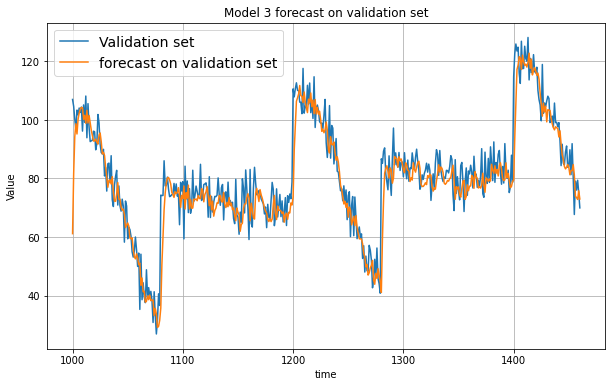

In [38]:
# plot forecast for the third model

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Validation set')
plot_series(time_valid, lin_forecast_3, label='forecast on validation set')
plt.title("Model 3 forecast on validation set")


It seems like the 3rd model more closely fits the validation data. I'm honestly baffled by the results of the second model, but i guess i should not be considering that the model was used to select the best learning rate

## **Using a more complex dense model**

find the best learning rate

In [42]:
model_4 = tf.keras.Sequential([
                               tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
                               tf.keras.layers.Dense(10, activation='relu'),
                               tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch/20))

model_4.compile(loss=tf.keras.losses.Huber(),
                optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
                metrics=["mae"])

history = model_4.fit(train_set_ds, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 34.3136 - mae: 34.8121 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 32.5546 - mae: 33.0540 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 30.5364 - mae: 31.0348 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 28.4163 - mae: 28.9144 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 26.2517 - mae: 26.7477 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 24.2132 - mae: 24.7083 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.4819 - mae: 22.9754 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 21.3066 - mae: 21.7991 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 20.5888 - mae: 21.0799 

(1e-07, 0.005, 0.0, 30.0)

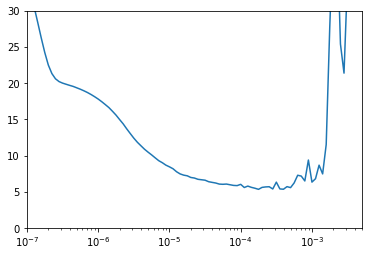

In [43]:
# plot the model loss against learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])


best learning rate is around 10e-4 - 10e-3

In [50]:
# Train a new model with the optimial learning rate

model_5 = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
                               tf.keras.layers.Dense(10, activation='relu'),
                               tf.keras.layers.Dense(1)])

model_5.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                metrics=["mae"])

model_5.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 10)                310       
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [51]:
# train the model with EarlyStopping callback

Early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

history = model_5.fit(train_set_ds, epochs=100,
                      validation_data=valid_set_ds,
                      callbacks=[Early_stopping])


Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 11.8819 - mae: 12.3745 - val_loss: 7.2836 - val_mae: 7.7699
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 6.5777 - mae: 7.0574 - val_loss: 6.6382 - val_mae: 7.1215
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 6.4681 - mae: 6.9501 - val_loss: 6.1858 - val_mae: 6.6655
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 5.6757 - mae: 6.1596 - val_loss: 5.5699 - val_mae: 6.0420
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 5.5305 - mae: 6.0125 - val_loss: 6.2162 - val_mae: 6.6971
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 5.5523 - mae: 6.0321 - val_loss: 5.6236 - val_mae: 6.1041
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 5.3286 - mae: 5.8066 - val_loss: 8.3964 - val_mae: 8.8824
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 5.3511 

Text(0.5, 1.0, 'Model 5 forecast on validation set')

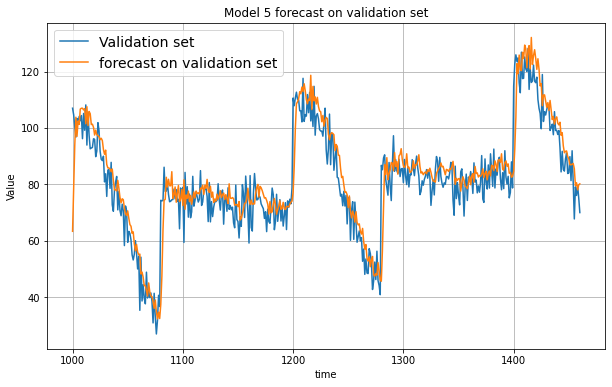

In [52]:
lin_forecast_5 = model_forecast(model_5, series[Split_time - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Validation set')
plot_series(time_valid, lin_forecast_5, label='forecast on validation set')
plt.title("Model 5 forecast on validation set")


## **Extra: Try applying differncing and smothing with trailing and centered window**